In [6]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

Loading BokehJS ...

### Notebook purpose: 
1. Perform NLP data preprocessing on ABC News Headline [dataset](!https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn/data)
1. Implement topic modeling using LDA / LSA algorithms included in nltk packages

In [1]:
!pip install nltk spacy gensim textblob bokeh plotly

     |████████████████████████████████| 24.1 MB 20.5 MB/s eta 0:00:01


In [41]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

In [15]:
raw_data = pd.read_csv('data/abcnews-date-text.csv', parse_dates=[0], infer_datetime_format=True)
reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']
show1(raw_data)
raw_data.head()

(1103663, 2) <class 'pandas.core.frame.DataFrame'>


,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


### EDA

Initiated with figsize (16, 8)


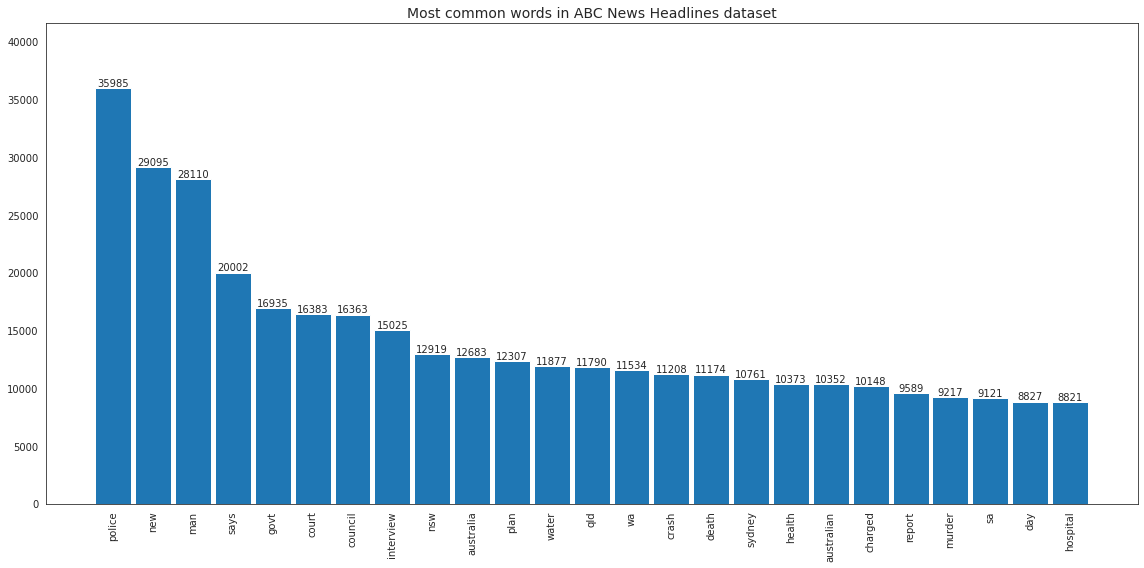

In [118]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

df1 = pd.DataFrame({'word_values':word_values, 'words':words})
viz1 = Viz(df = df1, figsize = (16,8))
fig, ax = viz1.make_barplot(x = 'words', height = 'word_values', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, title = ('Most common words in ABC News Headlines dataset',14),
                           xticklabels = df1['words'], xticklocs = range(len(df1['words'])), rotation = 90)

In [23]:
import nltk
nltk.download('punkt','averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [28]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  7079565
Mean number of words per headline:  6.414607538714264


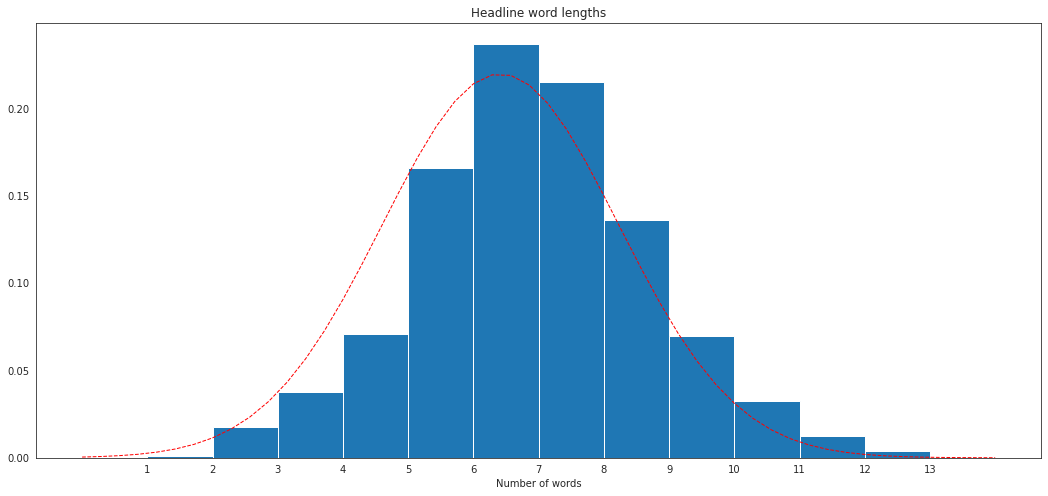

In [88]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

Initiated with figsize (16, 8)


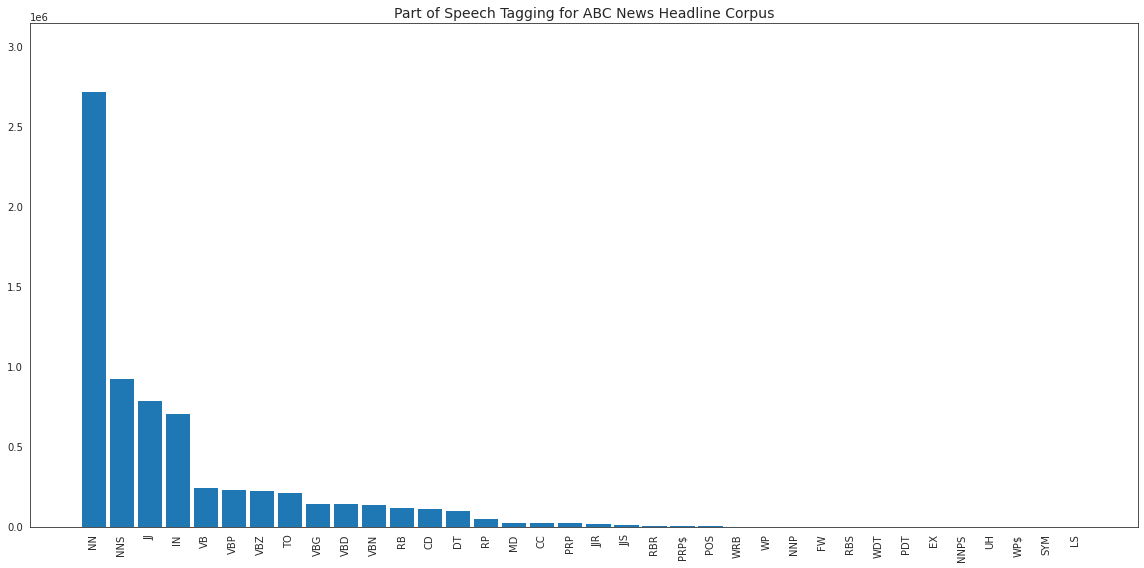

In [117]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)
df_pos = pd.DataFrame({'pos_sorted_types':pos_sorted_types, 'pos_sorted_counts':pos_sorted_counts})
viz2 = Viz(df = df_pos, figsize = (16,8))
fig, ax = viz2.make_barplot(x = 'pos_sorted_types', height = 'pos_sorted_counts', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = False, 
                            title = ('Part of Speech Tagging for ABC News Headline Corpus',14), xticklabels = df_pos['pos_sorted_types'], xticklocs = range(len(df_pos['pos_sorted_types'])), rotation = 90)

Initiated with figsize (18, 16)


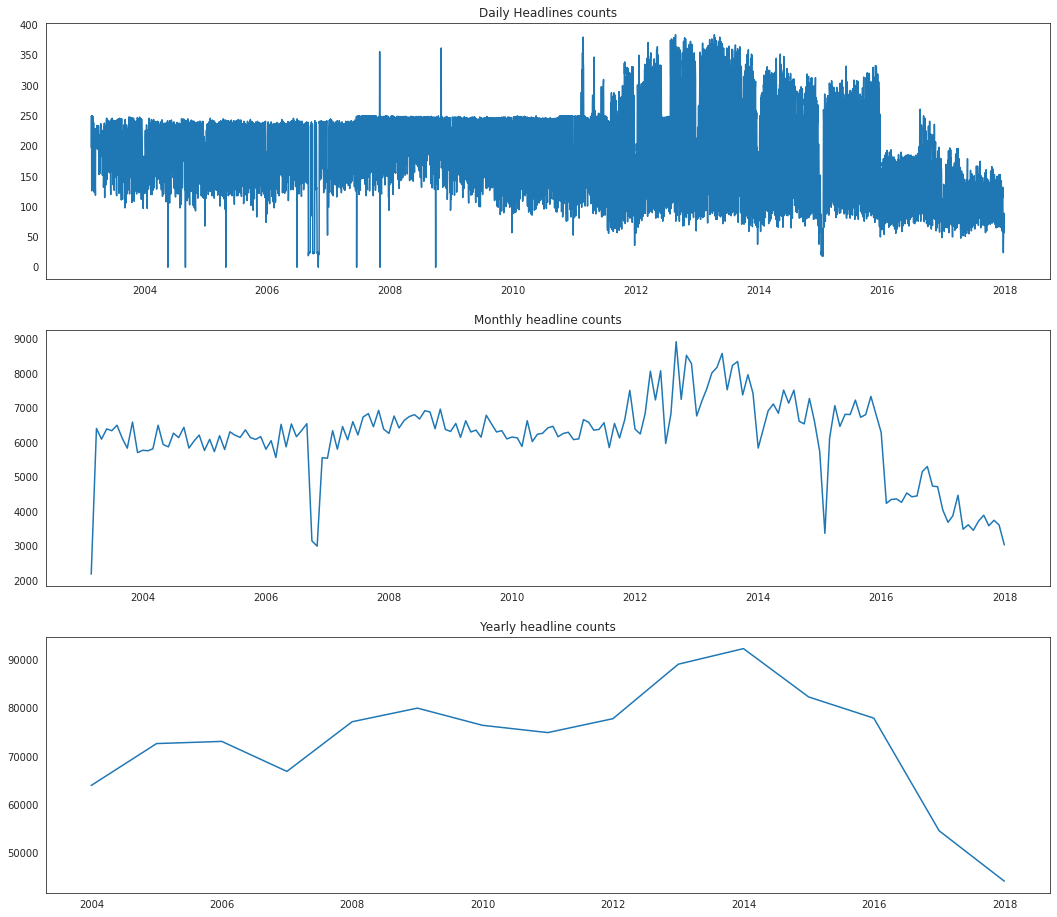

In [132]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

viz3 = Viz(figsize = (18, 16))
viz3.get_subplots(daily_counts, monthly_counts, yearly_counts, nplots = 3, titles = ('Daily Headlines counts', 'Monthly headline counts', 'Yearly headline counts'))

### Data preprocessing

In [ ]:
We experiment with various data preprocessing approaches to find out which is the most appropriate for our use case. We test:
1. Using sklearn CountVectorizer to remove stopwords only - no stemming or lemmatization involved 
1. Use nltk 

#### Approach 1: Using sklearn CountVectorizer to remove stopwords - no stemming or lemmatization involved
Adapting code from https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda/notebook

In [157]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

small_text_sample = reindexed_data.sample(n=10000, random_state=0).values
counter_vectorizer, document_term_matrix = words2vec(data = small_text_sample, max_features = 40000)

print('Before preprocessing ', small_text_sample[1])
print('Words converted to vector ', document_term_matrix[1])
print('Word vector inverse transformed to word output ', inv_transform_count_vectorizer(counter_vectorizer, document_term_matrix[1]))

0.1 sec to complete <function words2vec at 0x7f198e9ac0d0>
Before preprocessing  four freed from car crash in ocean reef
Words converted to vector    (0, 4549)	1
  (0, 2014)	1
  (0, 2854)	1
  (0, 7721)	1
  (0, 9074)	1
Word vector inverse transformed to word output  [array(['freed', 'car', 'crash', 'ocean', 'reef'], dtype='<U17')]


#### LSA

In [159]:
lsa_model = TruncatedSVD(n_components=8)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [161]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [205]:
top_n_words_lsa = get_top_words(n = 15, n_topics = 8, keys = lsa_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

1.6 sec to complete <function get_top_words at 0x7f198f6f5160>
Topic 1:  police death probe missing car drug woman search fatal attack shooting assault man investigate case
Topic 2:  man charged murder jailed dies court accused guilty arrested bail woman canberra stabbing death pleads
Topic 3:  new laws year cancer years queensland sets trial zealand centre york hope opens set ceo
Topic 4:  says wa government group school claims help power minister plans mp labor funding opposition support
Topic 5:  court face accused high trial sex charges ban told faces case set challenge hears murder
Topic 6:  govt qld urged sa plan hospital work act vic boost funds closer defends cut considers
Topic 7:  council election plan water takes centre calls backs fears business lake park residents start brisbane
Topic 8:  interview australia health nsw report world china coast win australian wins sydney cup day killed


In [224]:
lsa_categories = [7, 4, 3, 0, 6, 1, 2, 5]

1.3 sec to complete <function get_top_words at 0x7f198f6f5160>
Initiated with figsize (16, 8)


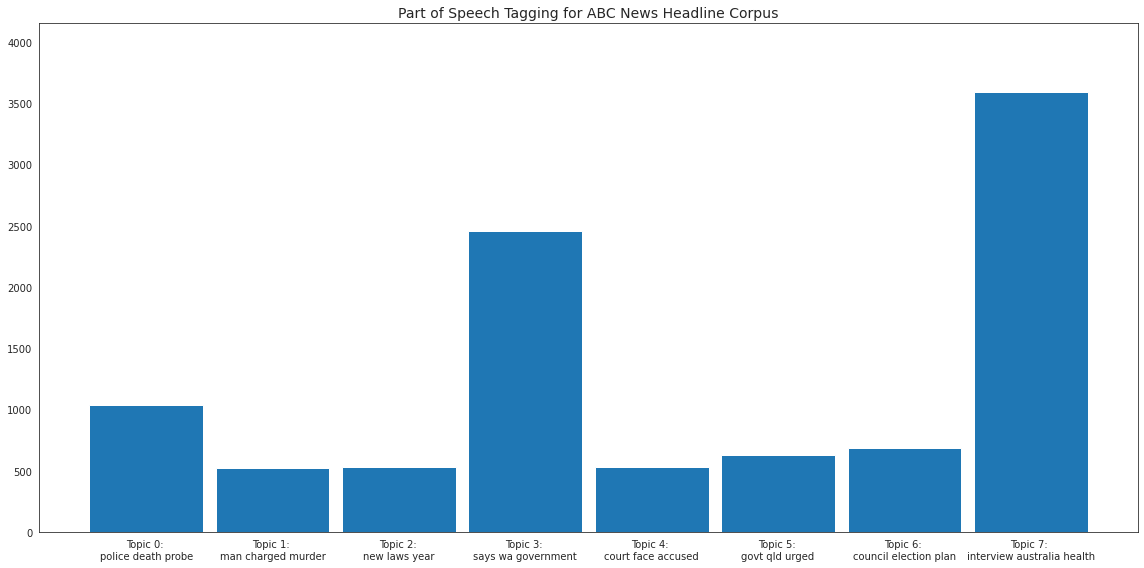

In [229]:
top_3_words = get_top_words(n = 3, n_topics = 8, keys = lsa_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

df2 = pd.DataFrame({'lsa_categories':lsa_categories, 'lsa_counts':lsa_counts})
df2.sort_values(by = 'lsa_categories', axis = 0, inplace = True)
labels.sort()
viz4 = Viz(df = df2, figsize = (16,8))
fig, ax = viz4.make_barplot(x = 'lsa_categories', height = 'lsa_counts', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = False, 
                            title = ('Part of Speech Tagging for ABC News Headline Corpus',14), xticklabels = labels, xticklocs = range(len(labels)), rotation = 0)

In [230]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.206757
[t-SNE] KL divergence after 2000 iterations: 1.219305


In [231]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [233]:
n_topics = 8

In [234]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [238]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], text=top_3_words[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

#### LDA

In [248]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [249]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [251]:
top_n_words_lda = get_top_words(n = 15, n_topics = n_topics, keys = lda_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

1.5 sec to complete <function get_top_words at 0x7f198f6f5160>
Topic 1:  police child calls day court says abuse dead change market missing climate claims nt vic
Topic 2:  council court coast murder gold government face says national police iraq drug man case news
Topic 3:  man charged police nsw sydney home road hit crash guilty jailed melbourne centre new pleads
Topic 4:  says wa death sa abc australian report open sex final laws mp action opposition safety
Topic 5:  new qld election ban country future trial end industry hour pay port dies company cancer
Topic 6:  interview australia world cup china south accused pm hill work rain jail ahead push team
Topic 7:  police health govt hospital plan boost car minister school house probe help wins set regional
Topic 8:  new water killed high attack public farmers funding police urged years charges continue woman oil


1.3 sec to complete <function get_top_words at 0x7f1981557160>
Initiated with figsize (16, 8)


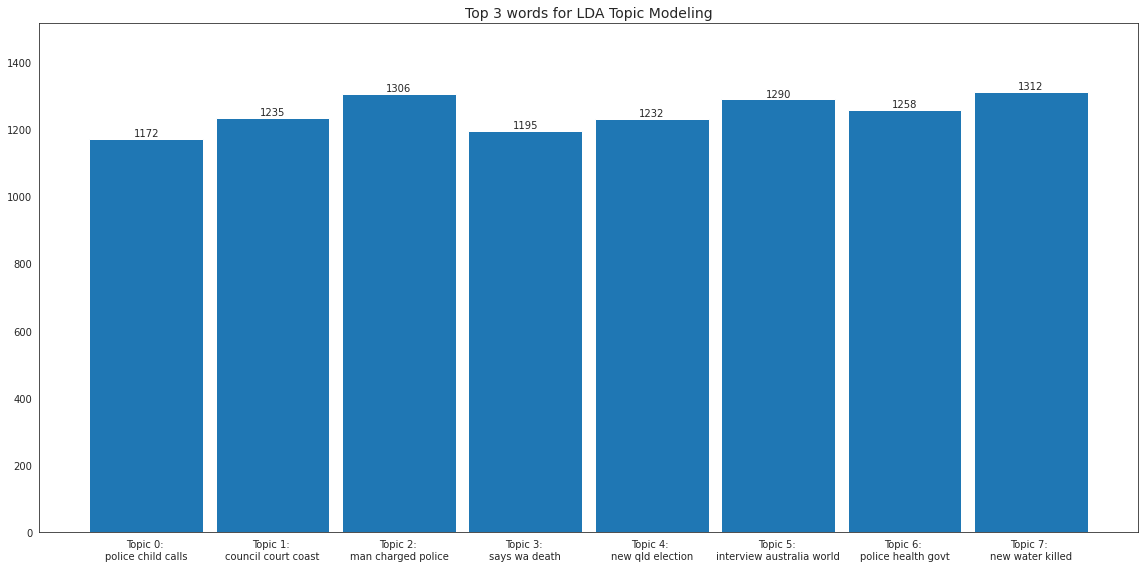

In [257]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *


top_3_words_lda = get_top_words(n = 3, n_topics = 8, keys = lda_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words_lda[i] for i in lda_categories]

df2 = pd.DataFrame({'lda_categories':lda_categories, 'lda_counts':lda_counts})
df2.sort_values(by = 'lda_categories', axis = 0, inplace = True)
labels.sort()
viz4 = Viz(df = df2, figsize = (16,8))
fig, ax = viz4.make_barplot(x = 'lda_categories', height = 'lda_counts', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, 
                            title = ('Top 3 words for LDA Topic Modeling',14), xticklabels = labels, xticklocs = range(len(labels)), rotation = 0)

In [256]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.756142
[t-SNE] KL divergence after 2000 iterations: 1.224056


In [259]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

### Scaling up LDA

In [261]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

big_sample_size = 100000
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_count_vectorizer, big_document_term_matrix = words2vec(data = big_text_sample, max_features = 40000)

print('Before preprocessing ', big_text_sample[1])
print('Words converted to vector ', big_document_term_matrix[1])
print('Word vector inverse transformed to word output ', inv_transform_count_vectorizer(big_count_vectorizer, big_document_term_matrix[1]))

0.5 sec to complete <function words2vec at 0x7f198e468550>
Before preprocessing  four freed from car crash in ocean reef
Words converted to vector    (0, 13367)	1
  (0, 6212)	1
  (0, 8591)	1
  (0, 23181)	1
  (0, 26920)	1
Word vector inverse transformed to word output  [array(['freed', 'car', 'crash', 'ocean', 'reef'], dtype='<U18')]


In [263]:
#fit scaled up LDA model
big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix)

LatentDirichletAllocation(learning_method='online', n_components=8)

In [273]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

yearly_data = []
for i in range(2003,2017+1):
    yearly_data.append(reindexed_data['{}'.format(i)].values)
    
yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

yearly_topic_counts.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
2003,7647,9078,8147,8976,7985,7578,7658,6934
2004,7575,9025,10425,9757,8559,10220,8293,8820
2005,8398,8080,10476,8402,9423,8855,10727,8763
2006,8285,7743,7682,10008,7597,8820,7269,9508
2007,8747,8518,8181,12479,10013,10720,9832,8702


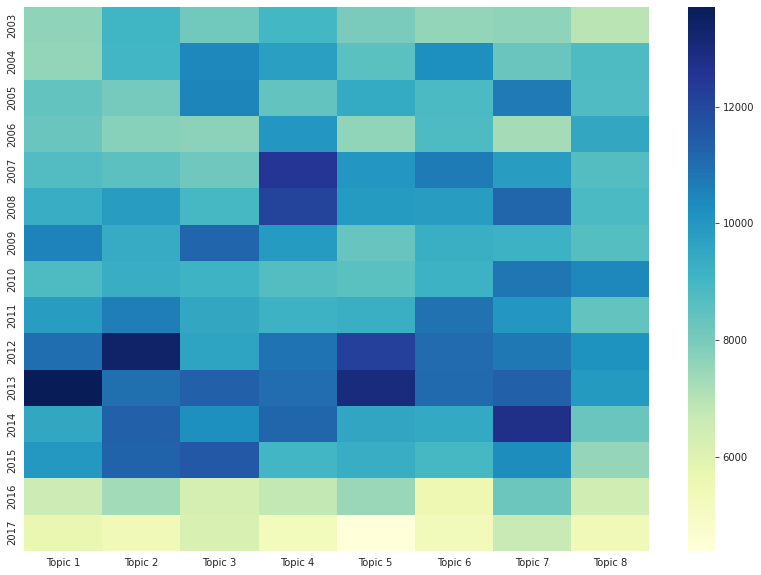

In [277]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

Initiated with figsize (16, 10)


(<Figure size 1152x720 with 1 Axes>, <AxesSubplot:>)

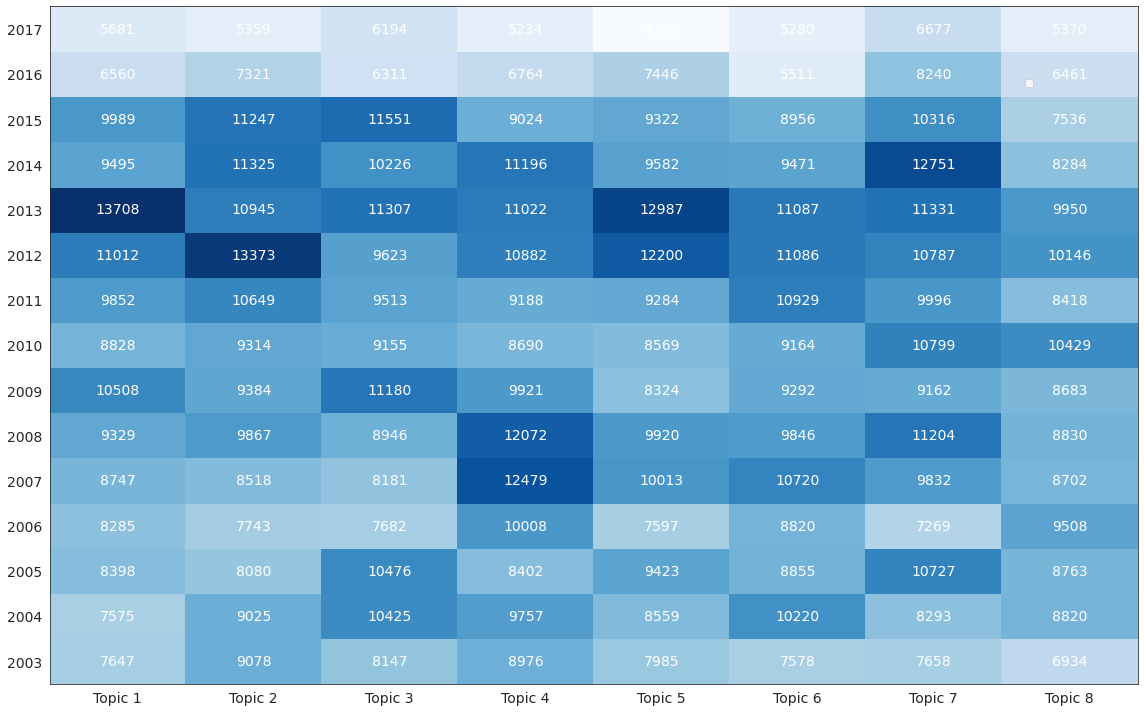

In [297]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

viz5 = Viz(figsize = (16,10))
viz5.make_corrheatmap(df = yearly_topic_counts, rotation = 0)

### Appendix

In [ ]:
#Viz class method template  
def make_(self, *cols, df = None, **kwargs):
        '''Method for creating a '''
        df = self.check_df(df)
        fig, ax = plt.subplots(figsize = self.figsize)
        ax = self.set_decorations(ax, **kwargs)
        
        self.download_fig(**kwargs)
        fig = ax.get_figure()
        fig.tight_layout()
        return fig, ax